In [ ]:

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
import gc
import warnings
warnings.filterwarnings ('ignore')



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
import pandas as pd
df = pd.read_csv('/drive/My Drive/apple_quality.csv')

In [ ]:
df_train = df.copy()
df_train

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
...,...,...,...,...,...,...,...,...,...
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


In [ ]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [ ]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

A_id: 4001 distinct values
Size: 4001 distinct values
Weight: 4001 distinct values
Sweetness: 4001 distinct values
Crunchiness: 4001 distinct values
Juiciness: 4001 distinct values
Ripeness: 4001 distinct values
Acidity: 4001 distinct values
Quality: 3 distinct values


<Axes: >

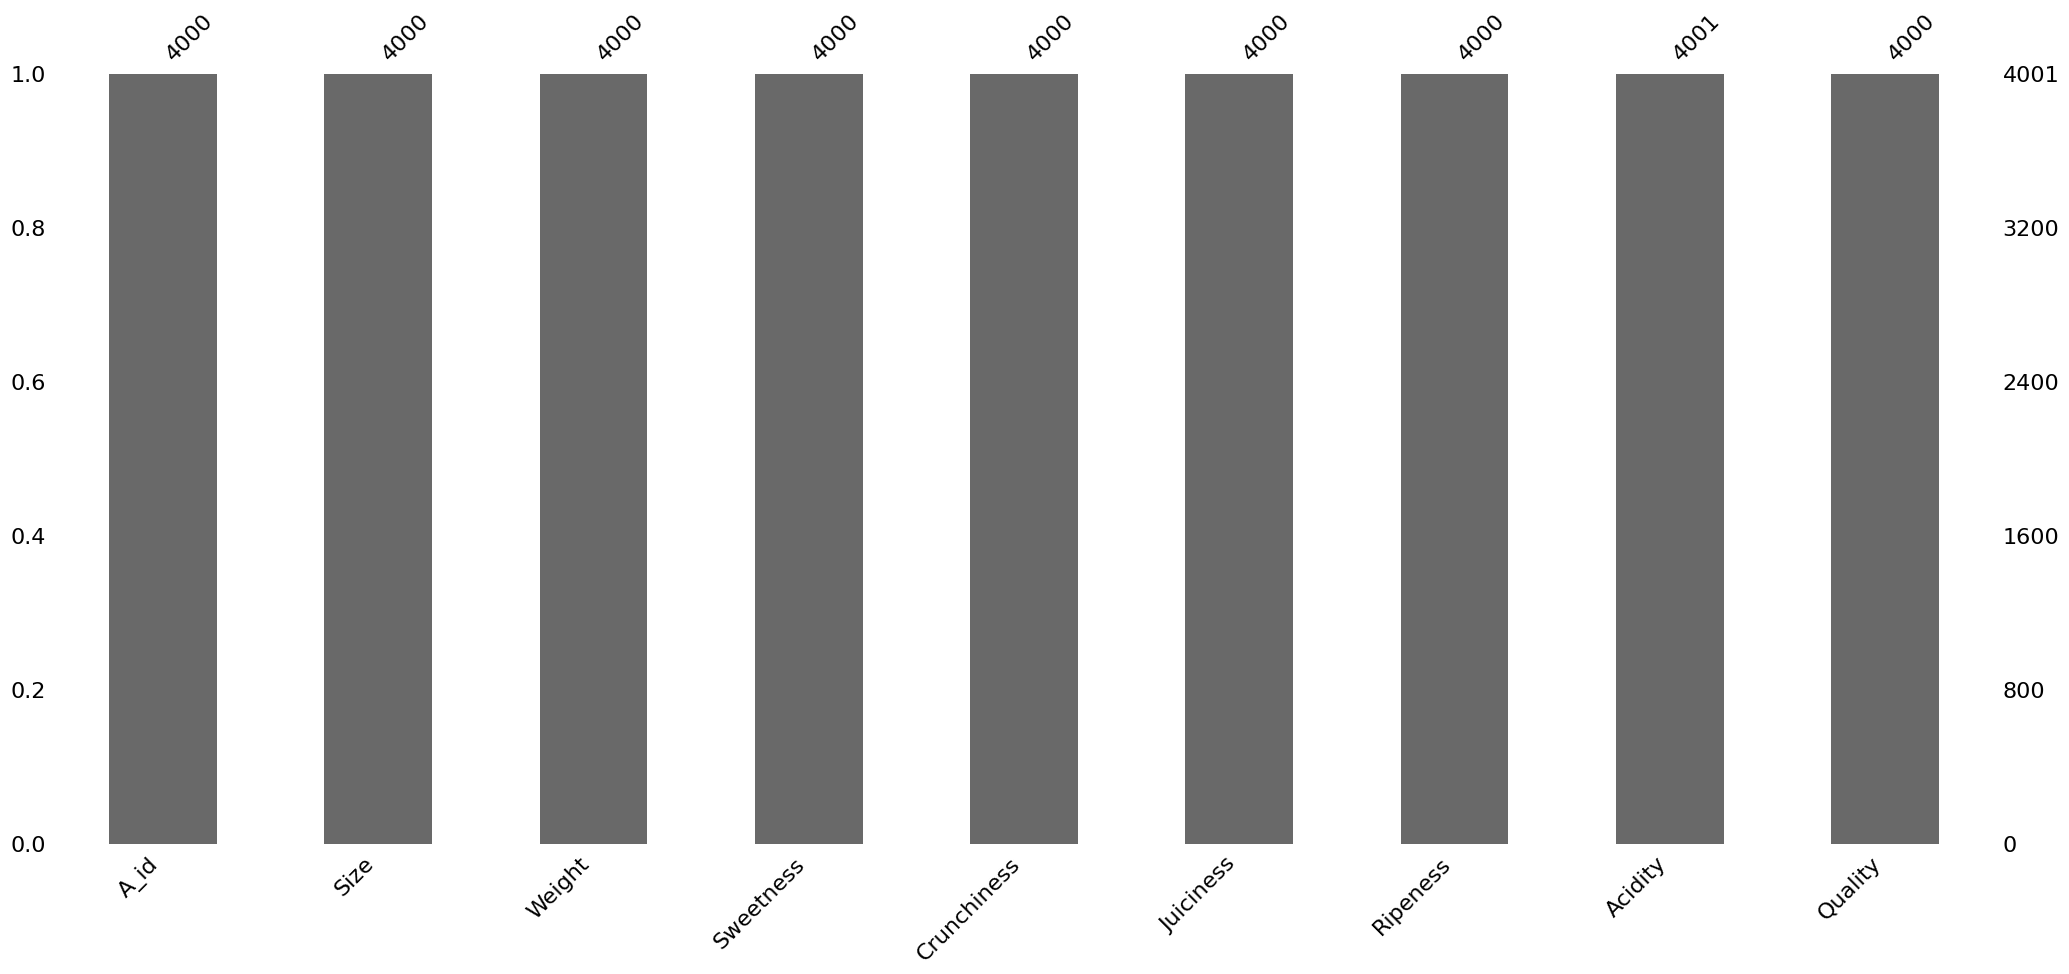

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.bar(df_train)

# Bar plot to visualize missing values



In [ ]:
df[df.isnull().any(axis = 1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [ ]:
def clean_data(df):

    df = df.drop(columns=['A_id'])
    df = df.dropna()
    df = df.astype({'Acidity': 'float64'})

    def label(Quality):
        """
        Transform based on the following examples:
        Quality    Output
        "good"  => 0
        "bad"   => 1
        """
        if Quality == "good":
            return 0

        if Quality == "bad":
            return 1

        return None

    df['Label'] = df['Quality'].apply(label)
    df = df.drop(columns=['Quality'])
    df = df.astype({'Label': 'int64'})

    return df

df_clean = clean_data(df.copy())
df_clean.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,0
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,0
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,1
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,0
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Label        4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


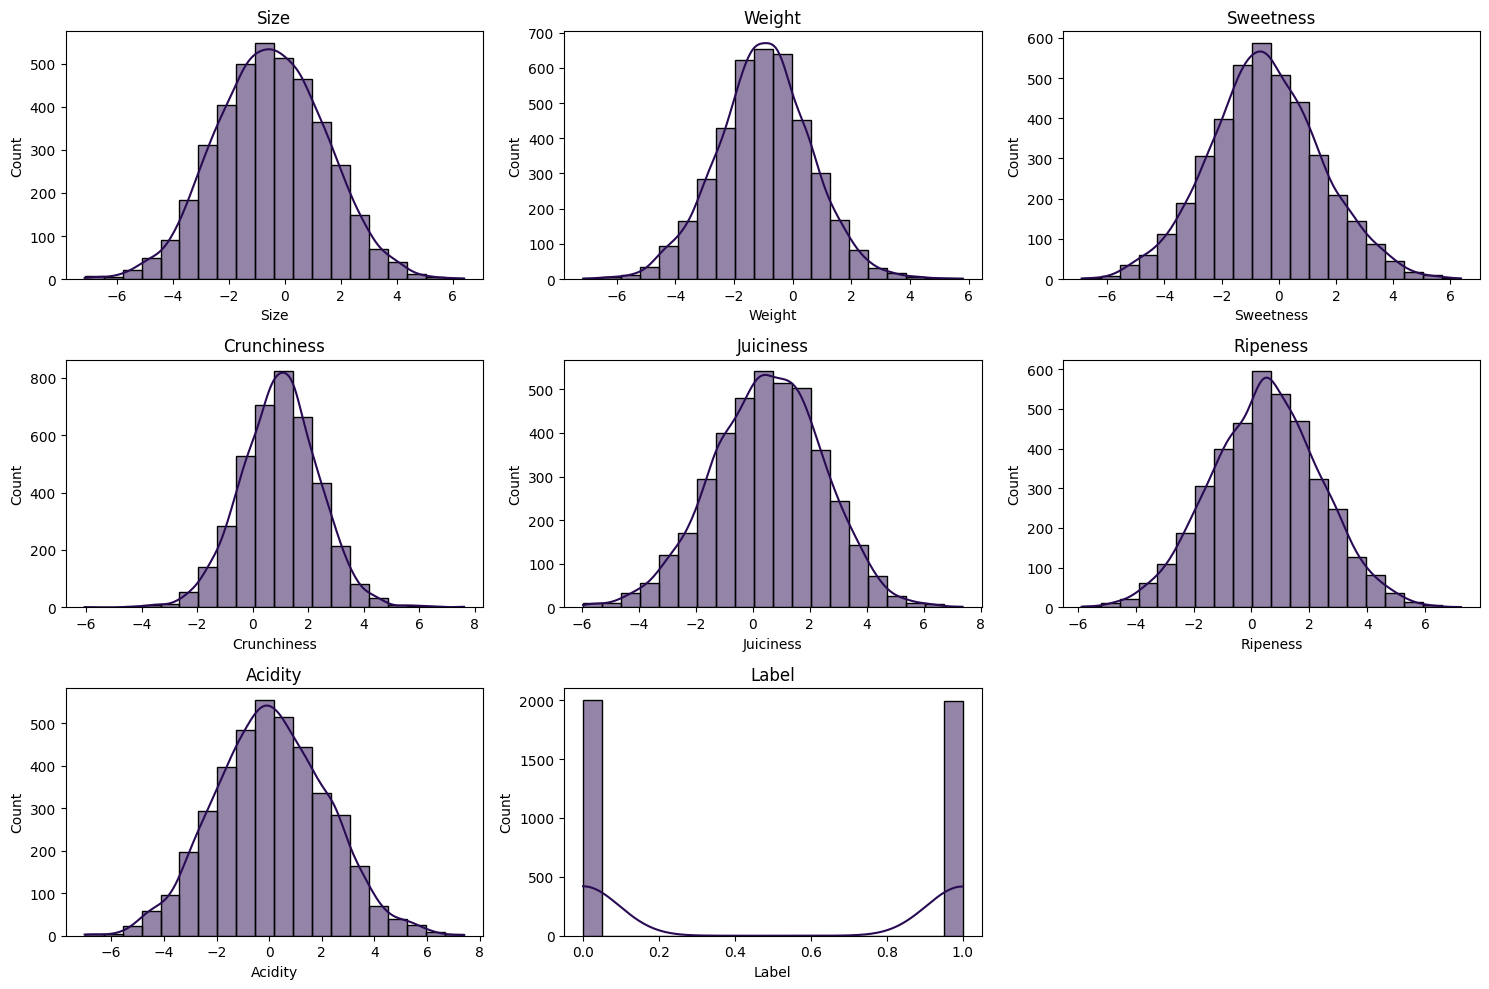

In [ ]:
numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Label']

plt.figure(figsize=(15, 10))
sns.set_palette("inferno")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True, bins=20)  # Use sns.histplot for newer versions
    plt.title(column)

plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

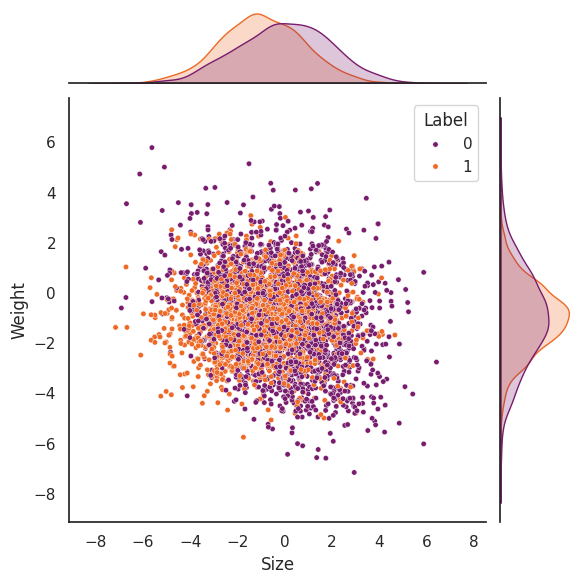

<Figure size 800x800 with 0 Axes>

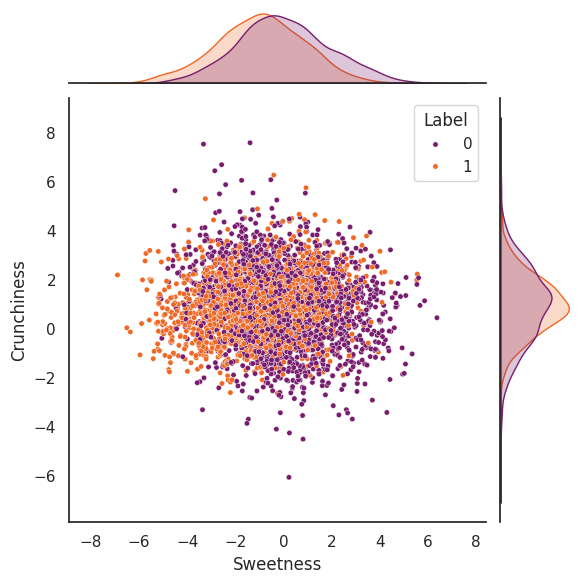

<Figure size 800x800 with 0 Axes>

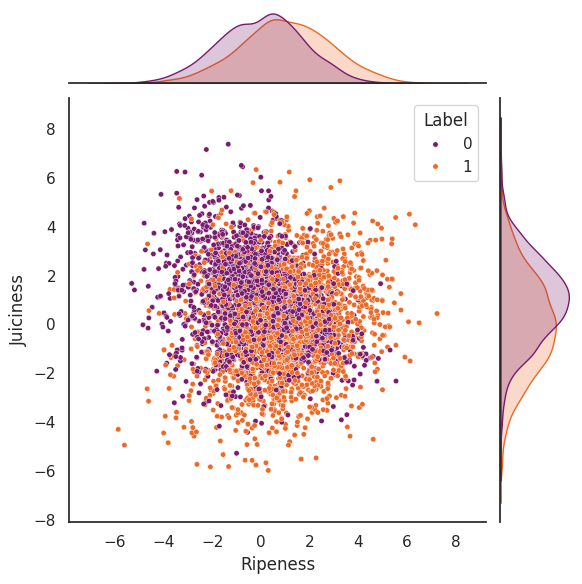

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="white")
sns.jointplot(x='Size', y='Weight', hue='Label', data=df_clean, palette='inferno', s=15)

plt.figure(figsize=(8, 8))
sns.set(style="white")
sns.jointplot(x='Sweetness', y='Crunchiness', hue='Label', data=df_clean, palette='inferno', s=15)

plt.figure(figsize=(8, 8))
sns.set(style="white")
sns.jointplot(x='Ripeness', y='Juiciness', hue='Label', data=df_clean, palette='inferno', s=15)

# **Data Preprocessing**

## **Outliers**

In [ ]:
numerical_features = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness',
       'Acidity']

robust_scaler = RobustScaler()

df_clean[numerical_features] = robust_scaler.fit_transform(df_clean[numerical_features])

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for feature in numerical_features :
    num_outliers = count_outliers(df_clean[feature])
    print(f'Number of outliers in {feature}: {num_outliers}')

Number of outliers in Size: 22
Number of outliers in Weight: 54
Number of outliers in Sweetness: 32
Number of outliers in Crunchiness: 47
Number of outliers in Juiciness: 32
Number of outliers in Ripeness: 24
Number of outliers in Acidity: 20


## **Imbalance in data**

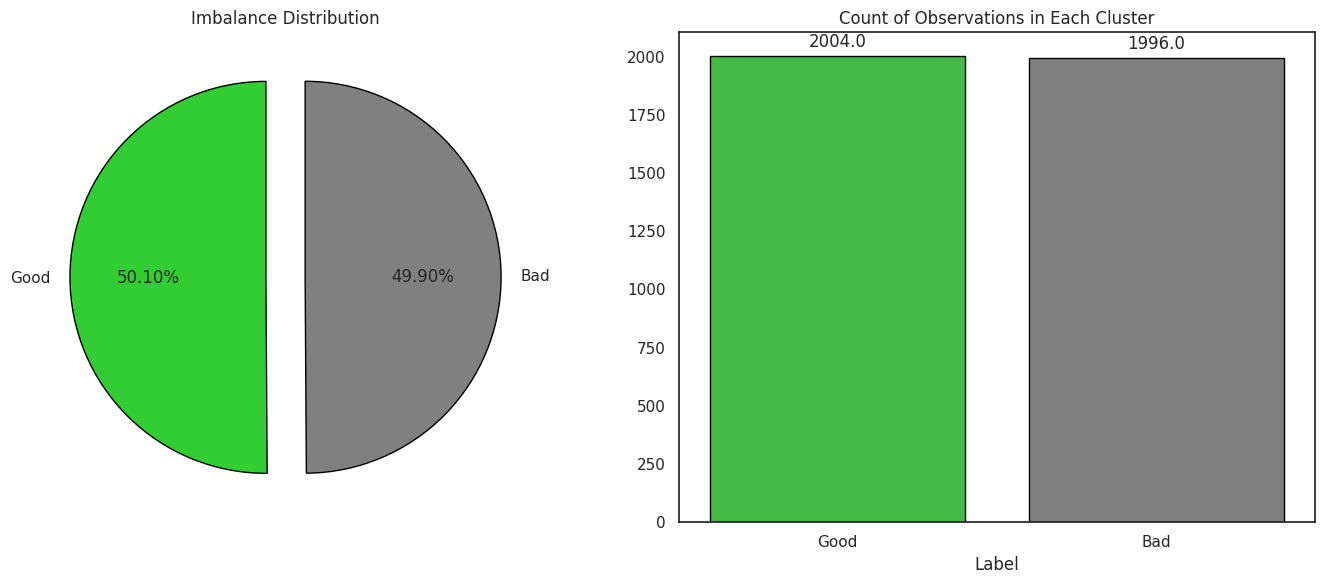

In [ ]:
good_count = df_clean['Label'].eq(0).sum()
bad_count = df_clean['Label'].eq(1).sum()
total_count = len(df_clean)

good_percentage = (good_count / total_count) * 100
bad_percentage = (bad_count / total_count) * 100

label_counts = df_clean['Label'].value_counts()

plt.figure(figsize=(14, 6))

# Subplot 1 - Pie Chart
plt.subplot(1, 2, 1)
pie_values = [good_percentage, bad_percentage]
colors = ['limegreen', 'grey']
plt.pie(pie_values, labels=['Good', 'Bad'],
        autopct='%1.2f%%',
        startangle=90,
        explode=(0.1, 0.1),
        colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Imbalance Distribution')

# Subplot 2 - Bar Chart
plt.subplot(1, 2, 2)
colors = ['limegreen', 'grey']
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors, edgecolor='black')
for i in ax.patches:
    ax.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Good', 'Bad'])
plt.title('Count of Observations in Each Cluster')

plt.tight_layout()
plt.show()

## **Normalization**

In [ ]:
df1 = df_clean.copy()
X = df1.drop(['Label'], axis=1)
y = df1['Label']
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
X_resampled.describe().T.style.background_gradient(axis=0, cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Size,4008.000000,0.490431,0.142145,0.000000,0.393548,0.489598,0.586959,1.000000
Weight,4008.000000,0.476027,0.123774,0.000000,0.397052,0.476383,0.554808,1.000000
Sweetness,4008.000000,0.483921,0.146609,0.000000,0.388526,0.481469,0.579613,1.000000
Crunchiness,4008.000000,0.514861,0.102545,0.000000,0.447492,0.515914,0.581305,1.000000
Juiciness,4008.000000,0.485754,0.144913,0.000000,0.387234,0.487180,0.585042,1.000000
Ripeness,4008.000000,0.485673,0.143085,0.000000,0.388877,0.486020,0.582625,1.000000
Acidity,4008.000000,0.491819,0.146420,0.000000,0.390824,0.487914,0.591137,1.000000


## **Split data (Train & Test)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

#**LightGBM Classfifer**

In [ ]:
param_dist_lgbm = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgbm = LGBMClassifier()

randomized_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_lgbm.fit(X_train, y_train)

best_params_lgbm = randomized_search_lgbm.best_params_
print(f"Best Hyperparameters for LGBMClassifier: {best_params_lgbm}")

best_lgbm_model = randomized_search_lgbm.best_estimator_

lgbm_predicted = best_lgbm_model.predict(X_test)

lgbm_acc_score = accuracy_score(y_test, lgbm_predicted)
lgbm_conf_matrix = confusion_matrix(y_test, lgbm_predicted)

print("\nConfusion Matrix for LGBMClassifier:")
print(lgbm_conf_matrix)
print("\nAccuracy of LGBMClassifier:", lgbm_acc_score * 100, '\n')
print("Classification Report for LGBMClassifier:")
print(classification_report(y_test, lgbm_predicted))

[LightGBM] [Info] Number of positive: 1614, number of negative: 1592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3206, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503431 -> initscore=0.013724
[LightGBM] [Info] Start training from score 0.013724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes